### TODO:

**GRAFICOS**
- [ ] criar grafico temporal
- [ ] criar grafico diario
- [ ] criar distribuicoes de ganho

**FUNCIONALIDADES**
- [ ] implementar preço açoes compradas no dia
- [ ] implementar subdivisao de acoes ao longo do tempo (qual valor usar?)
- [ ] como sera o input dos dados
- [ ] implementar interface com telegram
- [ ] implementar botoes para resultados especificos

In [1]:
import pandas as pd
import seaborn as sns
from pandas_datareader import data as web
from datetime import datetime
from matplotlib import pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import dotenv

In [108]:
class Stockz(object): 
    
    def __init__(self):
        
        # read xlsx
        self.portfolio_raw  = self.read_csv()
        # make dataframe stocks on columns
        self.portfolio_pivot  = self.make_pivot_portfolio(self.portfolio_raw)
        
        # get historical prices from yahoo finance
        self.historical_prices = self.get_historical_prices(self.portfolio_pivot)
        # get ibovespa historical prices from yahoo finance
        self.start_date = self.portfolio_pivot.index.min().strftime('%Y-%m-%d')
        #print('primeira data:', self.start_date)
        self.ibov = self.get_ibov(self.start_date)
        
        # make dataframe of historical portfolio weights
        self.portfolio_weights = self.make_portfolio_weights(self.portfolio_pivot, self.historical_prices)
        # get stocks daily gains
        self.stocks_gains = self.stocks_daily_gains(self.historical_prices)
        # weighted portfoli gains
        self.portfolio_gains = self.portfolio_daily_gains(self.portfolio_weights, self.stocks_gains)
        
        
    def read_csv(self):
        
        # get path to Stokz project
        self.path_to_stockz = os.getcwd().split('Stockz')[0].replace('\\', '/') + 'Stockz/'
        # get path to env variables
        self.dotenv_path = self.path_to_stockz + 'variables.env'
        #load env variables
        load_dotenv(self.dotenv_path)
        # get data path
        self.data_path = self.path_to_stockz + os.environ.get("data_path")
        
        print(f'Lendo o arquivo {self.data_path}')
        portfolio_raw = pd.read_excel(self.data_path)

        # assert if table has the right columns
        for col in ['DATA', 'TIPO', 'ATIVO', 'QTD']:
            assert col in portfolio_raw.columns , print(f'dataset nao possui a coluna {col}')
            
        # DATA to_datetime
        portfolio_raw['DATA'] = pd.to_datetime(portfolio_raw['DATA'])
            
        return portfolio_raw
    
    
    
    def make_pivot_portfolio(self, portfolio_raw):
                
        portfolio_pivot = portfolio_raw.copy()
        
        # multiply sotck sell count with -1
        portfolio_pivot.loc[portfolio_pivot.TIPO == 'VENDA', 'QTD'] *= -1
        # pivot tabele and make cummulative sum
        portfolio_pivot = portfolio_pivot.pivot('DATA', 'ATIVO', "QTD").cumsum()
        
        # add to pivot dates until now
        date_ini = portfolio_pivot.index.max() + pd.DateOffset(1)
        date_fin = datetime.now().strftime('%Y-%m-%d')
        date_range = pd.date_range(start = date_ini, end = date_fin )
    
        head = pd.DataFrame(portfolio_pivot.tail(1), index = date_range)
        portfolio_pivot = pd.concat([portfolio_pivot, head])

        # resample daily
        portfolio_pivot = portfolio_pivot.resample('D').first().ffill().fillna(0)
        
        # filter by todays date
        self.dt = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        portfolio_pivot = portfolio_pivot[portfolio_pivot.index < self.dt]

        return portfolio_pivot#.astype(int)
    
    
    def get_historical_prices(self, portfolio):
        
        prices = pd.DataFrame(index = portfolio.index)
        
        print('Buscando preco historico de', list(portfolio.columns))
        for i in portfolio.columns:
            prices[i] = web.DataReader(str(i)+'.SA', 
                                       data_source='yahoo', 
                                       start = portfolio.index.min().strftime('%Y-%m-%d')
                                      )['Close']
        return prices
    
    
    def get_ibov(self, start_date):
        return web.DataReader('^BVSP', data_source='yahoo', start=start_date)['Close']
    
    
    def make_portfolio_weights(self, portfolio, prices):
        
        self.portfolio_weights = prices*portfolio
        portfolio_weights = self.portfolio_weights
        
        portfolio_weights = portfolio_weights.dropna(how = 'all')
        portfolio_weights = portfolio_weights.div(portfolio_weights.sum(axis=1), axis=0)

        return portfolio_weights
    
    
    def stocks_daily_gains(self, prices):
    
        self.daily_gains = prices.dropna()
        
        self.daily_gains_shift = self.daily_gains.shift(1).copy()
        self.daily_gains = (self.daily_gains - self.daily_gains_shift)/self.daily_gains

        return self.daily_gains
    
    
    def portfolio_daily_gains(self, weights, gains):
        self.df = (weights * gains).sum(axis = 1)
        self.df += 1
        self.df = self.df.cumprod()

        return self.df
    
    
    def plot_historical_gains(self):
        sns.set_style("darkgrid")
        
        self.portfolio_gains.plot(figsize = (15,5))
        self.ibov_norm = self.ibov/self.ibov.iloc[0]
        self.ibov_norm.plot(figsize = (15,5))
        plt.show()
        
        return True
    

In [109]:
stockz = Stockz()


Lendo o arquivo C:/Users/guilherme.bonaldo/Desktop/Stockz/data/raw/compras.xlsx
Buscando preco historico de ['ABEV3', 'ALZR11', 'AZUL4', 'BIDI4', 'CIEL3', 'HGLG11', 'ITSA4', 'KNRI11', 'LLIS3', 'VVAR3']


In [112]:
stockz.portfolio_pivot.head()

ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2019-01-30,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-01-31,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-02,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-03,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0


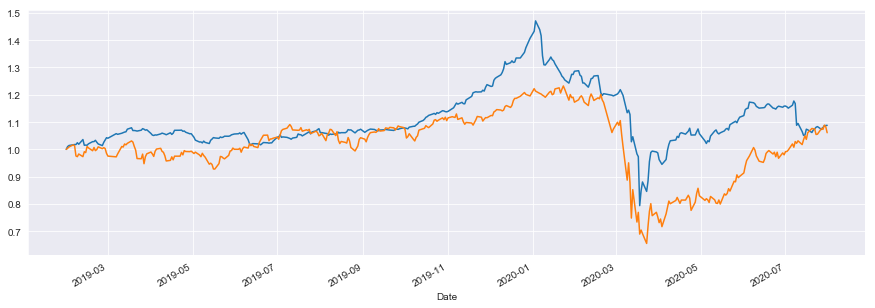

True

In [111]:
stockz.plot_historical_gains()

In [19]:
stockz.ibov

Date
2019-01-30     96996.0
2019-01-31     97394.0
2019-02-01     97861.0
2019-02-04     98589.0
2019-02-05     98311.0
                ...   
2020-07-27    104477.0
2020-07-28    104109.0
2020-07-29    105605.0
2020-07-30    105009.0
2020-07-31    102912.0
Name: Close, Length: 373, dtype: float64

In [20]:
stockz.portfolio_gains

DATA
2019-01-30    1.000000
2019-01-31    1.010241
2019-02-01    1.014298
2019-02-04    1.014024
2019-02-05    1.010896
                ...   
2020-07-15    1.056463
2020-07-16    1.070056
2020-07-17    1.069679
2020-07-20    1.064327
2020-07-21    1.073299
Length: 365, dtype: float64

In [30]:
portfolio_pivot = stockz.portfolio_raw.copy()

portfolio_pivot.loc[portfolio_pivot.TIPO == 'VENDA', 'QTD'] *= -1

portfolio_pivot = portfolio_pivot.pivot('DATA', 'ATIVO', "QTD")\
                                .cumsum()\
                                .ffill()\
                                .resample('D')\
                                .ffill()\
                                .fillna(0)

In [31]:
portfolio_pivot.resample('D')

ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
DATA,,,,,,,,,,
2019-01-30,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-01-31,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-02,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
2019-02-03,0.0,0.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-07-17,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-18,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-19,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0


In [53]:
date_ini = portfolio_pivot.index.max() + pd.DateOffset(1)
date_fin = datetime.now().strftime('%Y-%m-%d')
date_range = pd.date_range(start = date_ini, end = date_fin )

head = pd.DataFrame(portfolio_pivot.tail(1), index = date_range)

pd.concat([portfolio_pivot, head]).tail(15)

ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-07-19,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-20,10.0,10.0,10.0,0.0,10.0,60.0,10.0,30.0,0.0,10.0
2020-07-21,10.0,10.0,10.0,0.0,10.0,70.0,10.0,40.0,10.0,0.0
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ATIVO,ABEV3,ALZR11,AZUL4,BIDI4,CIEL3,HGLG11,ITSA4,KNRI11,LLIS3,VVAR3
2020-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
portfolio_pivot.index.max() + pd.DateOffset(1)

Timestamp('2020-07-22 00:00:00', freq='D')

In [ ]:
self.dt = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
portfolio_pivot = portfolio_pivot[portfolio_pivot.index < self.dt]